## ⚡ Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [3]:
!nvidia-smi

Thu Feb 22 17:32:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     Off | 00000000:05:00.0  On |                  N/A |
| 29%   46C    P5              16W / 250W |     92MiB / 11264MiB |     25%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 🧪 Install autodistill

**NOTE:** Autodistill is an ecosystem for using big, slower foundation models to train small, faster supervised models. Each Base, as well as the Target model, has its own separate repository and pip package.

In [ ]:
!pip install -q \
autodistill \
autodistill-grounded-sam \
autodistill-yolov8 \
roboflow \
supervision==0.9.0

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [4]:
import os
HOME = os.getcwd()
print(HOME)

/workspaces/solar_eyes/sandbox


## 🖼️ Image dataset preperation

**NOTE:** To use Autodistill all you need to have is a folder of images that you want to automatically annotate, and use for target model training.

In [5]:
!mkdir {HOME}/images

mkdir: cannot create directory ‘/workspaces/solar_eyes/sandbox/images’: File exists


## Download Images

Below, we provide two methods of retrieving images for use with Autodistill:

1. Download a dataset with images from Roboflow, and;
2. Download a raw video and split it up into images.

For this guide, we will be using a raw video to train our model.

### Download Images from Roboflow

You can download datasets from Roboflow using the below lines of code. You can download datasets associated with your account, or any of the 200,000+ public datasets on [Roboflow Universe](https://universe.roboflow.com/). To download a dataset from Roboflow, you will need a [free Roboflow account](https://app.roboflow.com).

You need to paste in a URL to a full model, like so:

```
https://universe.roboflow.com/mohamed-traore-2ekkp/taco-trash-annotations-in-context/model/16
```

To find a model URL, go to a dataset page on Universe (i.e. the [TACO dataset](https://universe.roboflow.com/mohamed-traore-2ekkp/taco-trash-annotations-in-context/)), then click "Model" in the sidebar to view the latest model version. Copy the page URL, then paste it into the `download_dataset()` function below.

![Universe model link](https://media.roboflow.com/universe_deploy_tab.png)

Uncomment the lines of code below to use the Roboflow dataset upload.

In [ ]:
import roboflow

roboflow.login()

dataset = roboflow.download_dataset(dataset_url="https://universe.roboflow.com/mohamed-traore-2ekkp/taco-trash-annotations-in-context/model/16", model_format="yolov8")

In [ ]:
!mkdir {HOME}/videos
%cd {HOME}/videos

# download zip file containing videos
!wget https://media.roboflow.com/milk.zip

# unzip videos
!unzip milk.zip

In [6]:
VIDEO_DIR_PATH = f"{HOME}/videos"
IMAGE_DIR_PATH = f"{HOME}/images"
FRAME_STRIDE = 10

**NOTE:** Notice that we put two of our videos aside so that we can use them at the end of the notebook to evaluate our model.

In [ ]:
import supervision as sv
from tqdm.notebook import tqdm

video_paths = sv.list_files_with_extensions(
    directory=VIDEO_DIR_PATH,
    extensions=["mov", "mp4"])

TEST_VIDEO_PATHS, TRAIN_VIDEO_PATHS = video_paths[:2], video_paths[2:]

for video_path in tqdm(TRAIN_VIDEO_PATHS):
    video_name = video_path.stem
    image_name_pattern = video_name + "-{:05d}.png"
    with sv.ImageSink(target_dir_path=IMAGE_DIR_PATH, image_name_pattern=image_name_pattern) as sink:
        for image in sv.get_video_frames_generator(source_path=str(video_path), stride=FRAME_STRIDE):
            sink.save_image(image=image)

### Display image sample

**NOTE:** Before we start building a model with autodistill, let's make sure we have everything we need.

In [7]:
import supervision as sv

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpeg"])

print('image count:', len(image_paths))

image count: 151


**NOTE:** We can also plot sample of our image dataset.

In [8]:
IMAGE_DIR_PATH = f"{HOME}/images"
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

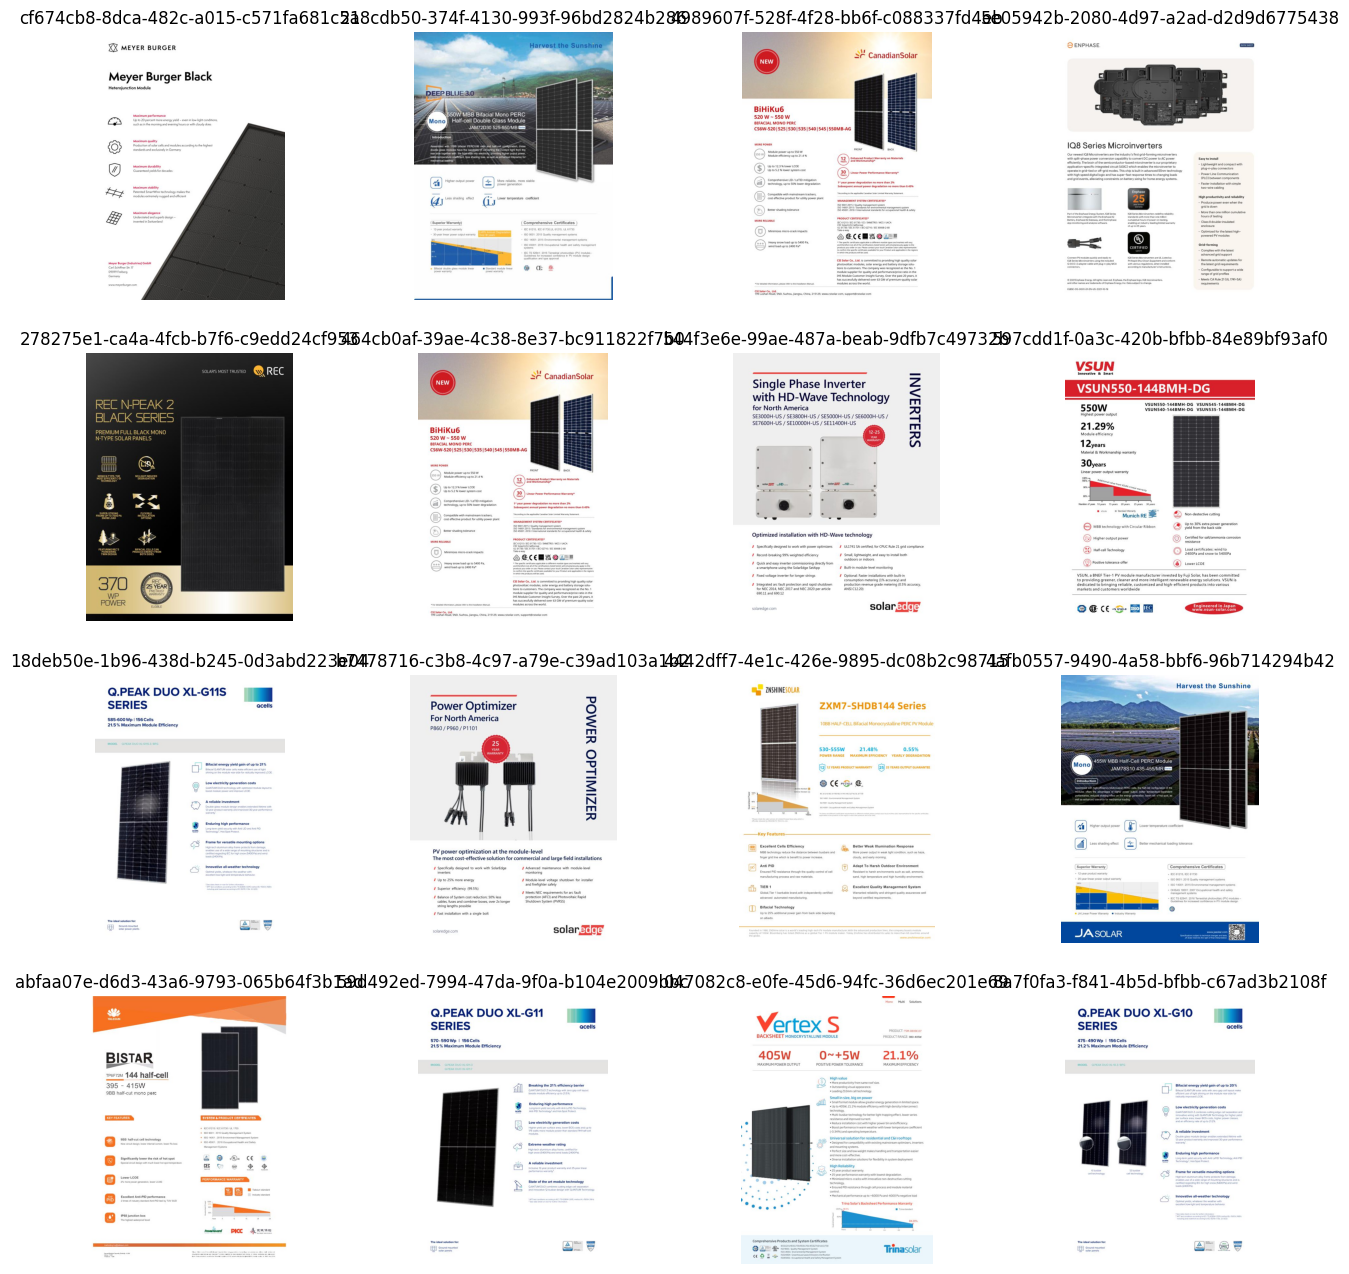

In [9]:
import cv2
import supervision as sv

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

## 🏷️ Autolabel dataset

### Define ontology

**Ontology** - an Ontology defines how your Base Model is prompted, what your Dataset will describe, and what your Target Model will predict. A simple Ontology is the CaptionOntology which prompts a Base Model with text captions and maps them to class names. Other Ontologies may, for instance, use a CLIP vector or example images instead of a text caption.

In [10]:
from autodistill.detection import CaptionOntology

ontology=CaptionOntology({
    "solar panel": "solar panel"
})

### Initiate base model and autolabel

**Base Model** - A Base Model is a large foundation model that knows a lot about a lot. Base models are often multimodal and can perform many tasks. They're large, slow, and expensive. Examples of Base Models are GroundedSAM and GPT-4's upcoming multimodal variant. We use a Base Model (along with unlabeled input data and an Ontology) to create a Dataset.

In [11]:
DATASET_DIR_PATH = f"{HOME}/dataset"

**NOTE:** Base Models are slow... Make yourself a coffee, autolabeing may take a while. ☕

In [12]:
from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology)


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


trying to load grounding dino directly
downloading dino model weights


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)


final text_encoder_type: bert-base-uncased


tokenizer_config.json: 100%|██████████| 48.0/48.0 [00:00<00:00, 262kB/s]
config.json: 100%|██████████| 570/570 [00:00<00:00, 1.23MB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 15.5MB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 41.5MB/s]
model.safetensors: 100%|██████████| 440M/440M [00:03<00:00, 113MB/s]  


In [13]:

dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".jpeg",
    output_folder=DATASET_DIR_PATH,
    record_confidence=True,
    human_in_the_loop=True,
    roboflow_project="sol-invictus"
    )

Labeling /workspaces/solar_eyes/sandbox/images/cf674cb8-8dca-482c-a015-c571fa681c51.jpeg:   0%|          | 0/151 [00:00<?, ?it/s]The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
Labeling /workspaces/solar_eyes/sandbox/images/dac84281-c973-4984-acc8-6d17be15bb26.jpeg: 100%|██████████| 151/151 [07:17<00:00,  2.90s/it]


Saved confidence file: /workspaces/solar_eyes/sandbox/dataset/annotations/confidence-cf674cb8-8dca-482c-a015-c571fa681c51.txt
Saved confidence file: /workspaces/solar_eyes/sandbox/dataset/annotations/confidence-2a8cdb50-374f-4130-993f-96bd2824b286.txt
Saved confidence file: /workspaces/solar_eyes/sandbox/dataset/annotations/confidence-4989607f-528f-4f28-bb6f-c088337fd4eb.txt
Saved confidence file: /workspaces/solar_eyes/sandbox/dataset/annotations/confidence-5e05942b-2080-4d97-a2ad-d2d9d6775438.txt
Saved confidence file: /workspaces/solar_eyes/sandbox/dataset/annotations/confidence-278275e1-ca4a-4fcb-b7f6-c9edd24cf953.txt
Saved confidence file: /workspaces/solar_eyes/sandbox/dataset/annotations/confidence-464cb0af-39ae-4c38-8e37-bc911822f7b0.txt
Saved confidence file: /workspaces/solar_eyes/sandbox/dataset/annotations/confidence-544f3e6e-99ae-487a-beab-9dfb7c49732b.txt
Saved confidence file: /workspaces/solar_eyes/sandbox/dataset/annotations/confidence-597cdd1f-0a3c-420b-bfbb-84e89bf93

UploadError: Bad response: <Response [502]>

### Display dataset sample

**Dataset** - a Dataset is a set of auto-labeled data that can be used to train a Target Model. It is the output generated by a Base Model.

In [14]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"

In [18]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

150

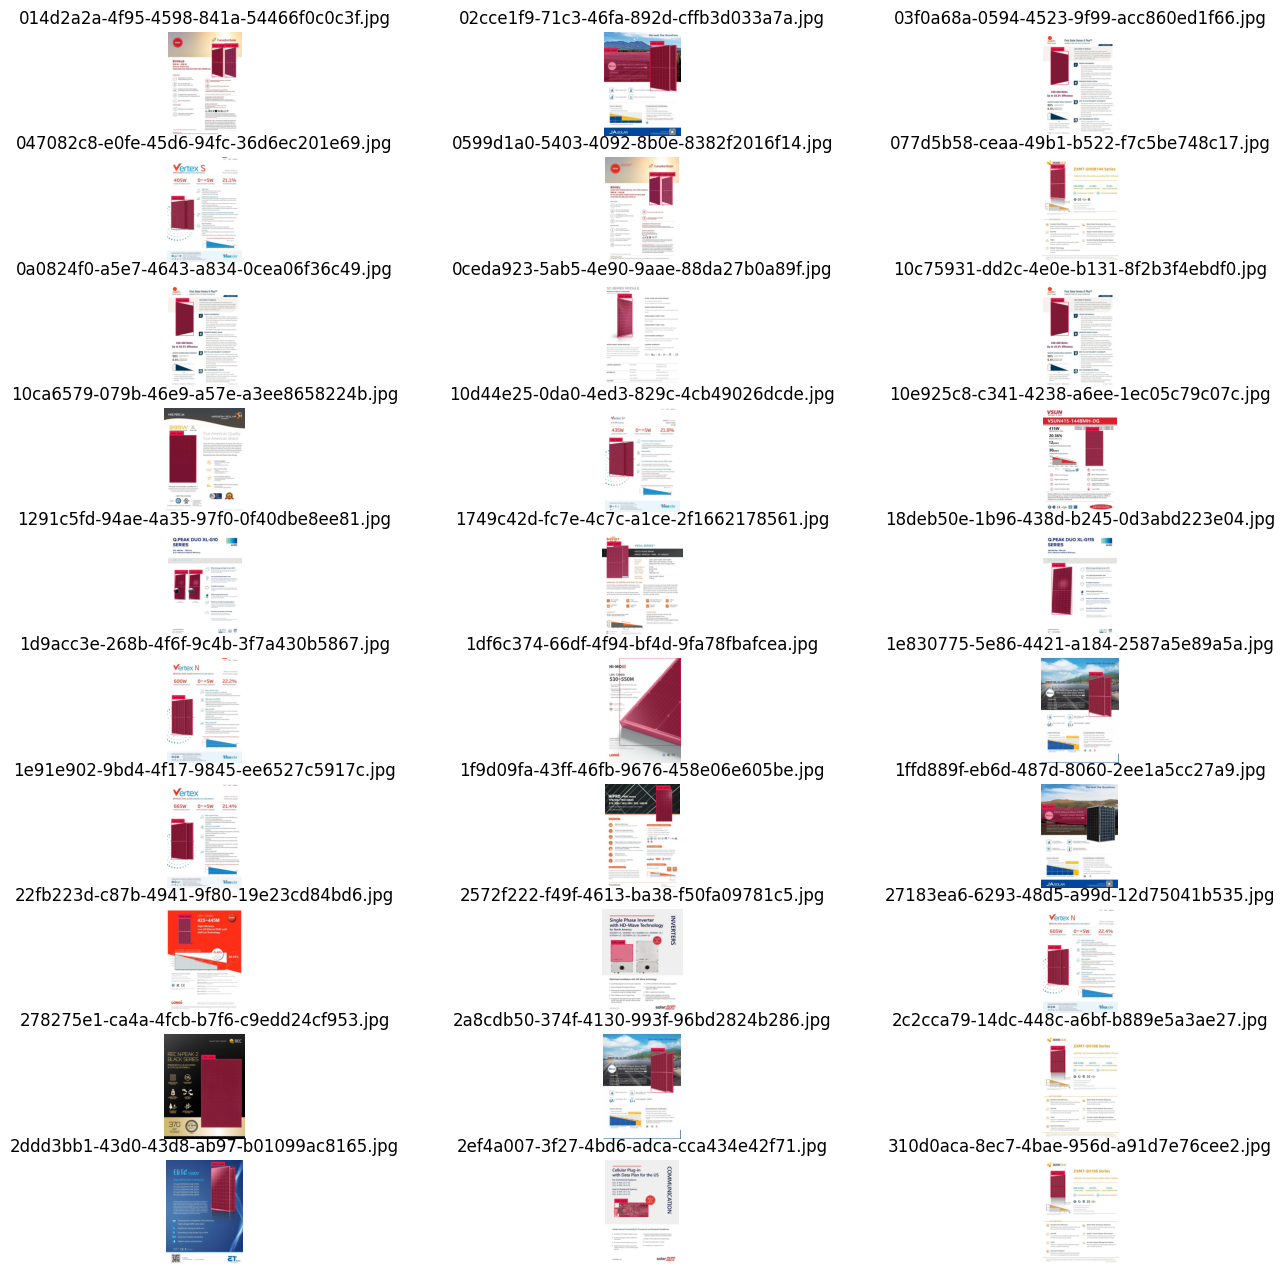

In [20]:
import supervision as sv

SAMPLE_SIZE = 30
SAMPLE_GRID_SIZE = (10, 3)
SAMPLE_PLOT_SIZE = (16, 16)

image_names = list(dataset.images.keys())
image_names.sort()
image_names = image_names[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

In [ ]:
import os

# Constants (Adjust these as needed)
FOLDER_PATH = './dataset/train/labels'  # Set your folder path here
CONFIDENCE_THRESHOLD = 0.52  # Set your confidence threshold here

def process_files_with_confidence_update(folder_path, confidence_threshold):
    # Find all polygon and confidence files
    polygon_files = [f for f in os.listdir(folder_path) if f.endswith('.txt') and not f.startswith('confidence-')]
    confidence_files = [f for f in os.listdir(folder_path) if f.startswith('confidence-')]

    for poly_file in polygon_files:
        uuid = poly_file[:-4]  # Remove '.txt' extension
        conf_file = f"confidence-{uuid}.txt"

        if conf_file in confidence_files:
            # Read and process files
            with open(os.path.join(folder_path, poly_file), 'r') as pf, open(os.path.join(folder_path, conf_file), 'r') as cf:
                polygon_lines = pf.readlines()
                confidence_lines = cf.readlines()

                # Filter polygon and confidence lines based on confidence threshold
                filtered_polygons = []
                filtered_confidences = []
                for poly_line, conf_line in zip(polygon_lines, confidence_lines):
                    if float(conf_line.strip()) >= confidence_threshold:
                        filtered_polygons.append(poly_line)
                        filtered_confidences.append(conf_line)

            # Write filtered data back to the files
            with open(os.path.join(folder_path, poly_file), 'w') as pf, open(os.path.join(folder_path, conf_file), 'w') as cf:
                pf.writelines(filtered_polygons)
                cf.writelines(filtered_confidences)

    print("Processing and confidence file update complete.")

# Example usage
process_files_with_confidence_update(FOLDER_PATH, CONFIDENCE_THRESHOLD)

# Note: Uncomment the above line and adjust the FOLDER_PATH and CONFIDENCE_THRESHOLD to use the script.


In [ ]:
import torch
torch.cuda.is_available()

## 🔥 Train target model - YOLOv8

**Target Model** - a Target Model is a supervised model that consumes a Dataset and outputs a distilled model that is ready for deployment. Target Models are usually small, fast, and fine-tuned to perform a specific task very well (but they don't generalize well beyond the information described in their Dataset). Examples of Target Models are YOLOv8 and DETR.

In [ ]:
%cd {HOME}

from ultralytics import YOLO

target_model = YOLO("yolov8s.pt")
target_model.train(data=DATA_YAML_PATH, epochs=50, device="0,1,2")

In [ ]:
!ls {HOME}/runs/detect/train5/

## ⚖️ Evaluate target model

**NOTE:** As with the regular YOLOv8 training, we can now take a look at artifacts stored in `runs` directory.

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train5/confusion_matrix.png', width=600)

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train5/results.png', width=600)

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train5/val_batch0_pred.jpg', width=600)

## 🎬 Run Inference on a video

In [ ]:
INPUT_VIDEO_PATH = TEST_VIDEO_PATHS[0]
OUTPUT_VIDEO_PATH = f"{HOME}/output.mp4"
TRAINED_MODEL_PATH = f"{HOME}/runs/detect/train/weights/best.pt"

In [ ]:
!yolo predict model={TRAINED_MODEL_PATH} source={INPUT_VIDEO_PATH}

## Upload dataset and model to Roboflow

comming soon...

  # 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.